In [3]:
import pandas as pd
import numpy as np
import nltk
from langdetect import detect
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from wordcloud import WordCloud
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

In [2]:
reviews=pd.read_csv('reviews.csv')

In [3]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836586 entries, 0 to 836585
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     836586 non-null  int64 
 1   id             836586 non-null  int64 
 2   date           836586 non-null  object
 3   reviewer_id    836586 non-null  int64 
 4   reviewer_name  836578 non-null  object
 5   comments       835850 non-null  object
dtypes: int64(3), object(3)
memory usage: 38.3+ MB


In [4]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...


In [3]:
reviews.dropna(inplace=True)

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835842 entries, 0 to 836585
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     835842 non-null  int64 
 1   id             835842 non-null  int64 
 2   date           835842 non-null  object
 3   reviewer_id    835842 non-null  int64 
 4   reviewer_name  835842 non-null  object
 5   comments       835842 non-null  object
dtypes: int64(3), object(3)
memory usage: 44.6+ MB


In [7]:
reviews['date'] = pd.to_datetime(reviews['date'])

In [8]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835842 entries, 0 to 836585
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   listing_id     835842 non-null  int64         
 1   id             835842 non-null  int64         
 2   date           835842 non-null  datetime64[ns]
 3   reviewer_id    835842 non-null  int64         
 4   reviewer_name  835842 non-null  object        
 5   comments       835842 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 44.6+ MB


In [9]:
reviews['year'] = reviews.date.dt.year

In [10]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,year
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...,2009
1,2595,19176,2009-12-05,53267,Cate,Great experience.,2009
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...,2009
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en...",2010
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...,2010


In [11]:
reviews.year.value_counts()

2019    239019
2018    170187
2017    115789
2020    106662
2016     80245
2015     46326
2021     32461
2014     23391
2013     11845
2012      6176
2011      2952
2010       696
2009        93
Name: year, dtype: int64

# Dataset is too large to run recommendation system on Streamlit. Need to use a subset 

In [12]:
reviews.year.dtype

dtype('int64')

In [13]:
#use only 2019-2021 data
df = reviews[(reviews['year'] == 2019) | (reviews['year'] == 2020)| (reviews['year'] == 2021)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378142 entries, 42 to 836585
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   listing_id     378142 non-null  int64         
 1   id             378142 non-null  int64         
 2   date           378142 non-null  datetime64[ns]
 3   reviewer_id    378142 non-null  int64         
 4   reviewer_name  378142 non-null  object        
 5   comments       378142 non-null  object        
 6   year           378142 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 23.1+ MB


In [14]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,year
42,2595,366477703,2019-01-02,165354250,Jacob,The apartment met expectations to how it was i...,2019
43,2595,449815873,2019-05-07,168460710,Christopher,10 / 10 would stay again,2019
44,2595,456489109,2019-05-21,119626931,Alex,Place was so cute and comfy! Host was great an...,2019
45,2595,487972917,2019-07-14,60181725,Andrew,I'm glad I stayed here. I liked everything.\nT...,2019
46,2595,514642186,2019-08-21,33952280,Laura,"First of all I have to say, that Jennifer is n...",2019


In [15]:
# keep only reviews in English
# replace non-english comments with 'Not English'
def non_eng(x):
    try:
        if detect(x) != 'en':
            return 'Not English'
    except:
        pass
# create a new column for whether the comments are in English
df['is_english']=df.comments.apply(non_eng)

<ipython-input-15-cded8424db09>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_english']=df.comments.apply(non_eng)


In [17]:
english_reviews = df[df['is_english'] != 'Not English']
english_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338459 entries, 42 to 836585
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   listing_id     338459 non-null  int64         
 1   id             338459 non-null  int64         
 2   date           338459 non-null  datetime64[ns]
 3   reviewer_id    338459 non-null  int64         
 4   reviewer_name  338459 non-null  object        
 5   comments       338459 non-null  object        
 6   year           338459 non-null  int64         
 7   is_english     0 non-null       object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 23.2+ MB


In [18]:
#drop is_english column
english_reviews.drop(columns='is_english', inplace=True)

C:\Users\sandy\anaconda3_2nd_download\envs\metis\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

english_reviews['comments'] = reviews.comments.map(alphanumeric).map(punc_lower)
english_reviews.head()

<ipython-input-16-2473a685454b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments'] = reviews.comments.map(alphanumeric).map(punc_lower)


,listing_id,id,date,reviewer_id,reviewer_name,comments,year,is_english
42,2595,366477703,2019-01-02,165354250,Jacob,the apartment met expectations to how it was i...,2019,None
43,2595,449815873,2019-05-07,168460710,Christopher,would stay again,2019,None
44,2595,456489109,2019-05-21,119626931,Alex,place was so cute and comfy host was great and...,2019,None
45,2595,487972917,2019-07-14,60181725,Andrew,im glad i stayed here i liked everything\nthe ...,2019,None
46,2595,514642186,2019-08-21,33952280,Laura,first of all i have to say that jennifer is no...,2019,None


In [19]:
# remove \n 
english_reviews['comments'] = english_reviews['comments'].str.replace('\n', ' ')

<ipython-input-19-077956673d20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['comments'] = english_reviews['comments'].str.replace('\n', ' ')


In [20]:
english_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,year
42,2595,366477703,2019-01-02,165354250,Jacob,the apartment met expectations to how it was i...,2019
43,2595,449815873,2019-05-07,168460710,Christopher,would stay again,2019
44,2595,456489109,2019-05-21,119626931,Alex,place was so cute and comfy host was great and...,2019
45,2595,487972917,2019-07-14,60181725,Andrew,im glad i stayed here i liked everything the a...,2019
46,2595,514642186,2019-08-21,33952280,Laura,first of all i have to say that jennifer is no...,2019


In [21]:
english_reviews.to_csv('english_subset.csv', index=False)

(array([3.14987e+05, 1.94790e+04, 2.85000e+03, 6.91000e+02, 2.27000e+02,
        1.11000e+02, 5.60000e+01, 2.40000e+01, 1.50000e+01, 1.90000e+01]),
 array([1.000e+00, 1.070e+02, 2.130e+02, 3.190e+02, 4.250e+02, 5.310e+02,
        6.370e+02, 7.430e+02, 8.490e+02, 9.550e+02, 1.061e+03]),
 <BarContainer object of 10 artists>)

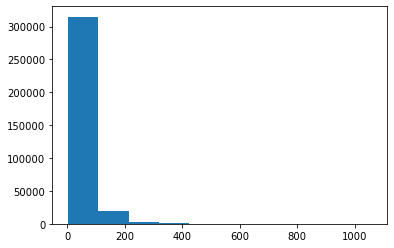

In [24]:
# distribution of number of words in reviews
plt.hist(english_reviews.comments.str.count(' ') + 1)

In [ ]:
subset = pd.read_csv('english_subset.csv')

In [87]:
subset = subset.rename(columns={"id": "review_id", "comments": "reviews"})

In [101]:
subset.to_csv('subset2.csv', index=False)

In [4]:
subset = pd.read_csv('subset2.csv')

In [5]:
subset.duplicated().sum()

0

In [6]:
subset.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,reviews,year
0,3831,721596793,2021-01-03,367990285,Mayra,i really like it she was nice and the places w...,2021
1,3831,722183142,2021-01-05,380514843,Jaami,you can expect a clean large space the host i...,2021
2,3831,723999945,2021-01-13,381460279,Matthew,great location great communication and great h...,2021
3,3831,724924853,2021-01-17,141222105,Tim And Lisa,great location the rooms were clean and comfor...,2021
4,3831,726611179,2021-01-24,24411345,Noah,great place,2021


In [7]:
subset.dtypes

listing_id        int64
review_id         int64
date             object
reviewer_id       int64
reviewer_name    object
reviews          object
year              int64
dtype: object

In [5]:
subset.review_id = subset.review_id.astype('str')

In [15]:
subset[subset['review_id'] == '721596793']

,listing_id,review_id,date,reviewer_id,reviewer_name,reviews,year
0,3831,721596793,2021-01-03,367990285,Mayra,i really like it she was nice and the places w...,2021


In [16]:
subset.iloc[0, 5]

'i really like it she was nice and the places was organize and clean'

In [5]:
# stopwords to remove from corpus
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['nyc','york', 'stayed', 'really', 'person', 'definitely', 'thank', 'thanks', 'staying', 'looking', 'just', 'stay',
               'also', 'get', 'would', 'aa', 'aaa', 'aaaa', 'aaaaa', 'us', 'great', 'mirco', 'snes', 'myrdith', 'chandra', 'place', 
               'dolores', 'chen', 'even', 'monifa', 'dalton', 'well', 'mk', 'made', 'sahr', 'jt', 'thiago', 'hanna', 'shelly', 'faye',
               'jamilya', 'bertha', 'aya', 'loyda', 'mete', 'tiziana', 'curtis', 'haythem', 'tio', 'however', 'bit', 'regina', 'erica',
               'jenn','edgar', 'jeffrey', 'antonio', 'beatrix', 'tina', 'jesse', 'sammy', 'monika', 'freda', 'kelvin', 'sadie', 'mo',
               'aleksandra', 'elvin', 'farhan', 'jhon', 'jade', 'barry', 'ingrid', 'kem', 'heide', 'je', 'nice', 'like', 'nathan', 'chad',
               'yochi', 'raquel', 'kent', 'zach', 'christa', 'pamela', 'maralla', 'richelle', 'jeannie', 'bernardo', 'kyisvu', 'lauren',
               'gina', 'lucien', 'gus', 'herman', 'darnell', 'wasnt', 'joseph', 'iso', 'emily', 'tracy', 'lynn', 'charlene', 'ronnie', 
               'rosa', 'jackie', 'reka', 'dante', 'dominik', 'rhita', 'pela', 'mia', 'martin', 'sean', 'sara', 'kimberley', 'alexandre', 
               'though', 'soon', 'victor', 'caroline', 'viviana', 'ron', 'matt', 'nick', 'tim', 'robin', 'monica', 'xavier', 'patricia',
               'marjorie', 'teddy', 'maxime', 'loli', 'blanca', 'andressa', 'paulo', 'stacey', 'gillian', 'ross', 'dani', 'susi', 'agnes',
               'javier', 'charisse', 'didnt', 'susi', 'lisas', 'christa', 'elle', 'ever', 'lakshan', 'yuval', 'laurenta', 'everything', 
               'jalen', 'albert', 'joe', 'lucilu', 'greg', 'conrad', 'jeff', 'frances', 'zachs', 'nadir', 'cara', 'olzhas', 'rena',
               'petra', 'kat', 'laurens', 'gane', 'charles', 'martha', 'nora', 'jared', 'britt', 'abe', 'carrie', 'penny', 'harvin',
               'lory', 'vikas', 'remi', 'tonia', 'svetlana', 'seans','holly', 'got', 'dont', 'know', 'let', 'could', 'absolutely',
               'take', 'youre', 'quite', 'need', 'want', 'day', 'back', 'gave', 'enough', 'airbnb', 'anyone', 'ok', 'brooklyn', 'perfect',
               'highly', 'amazing', 'location', 'manhattan', 'good', 'night', 'super', 'one', 'overall', 'two', 'say', 'another', 'said', 
               'people', 'awesome', 'highly', 'loved', 'enjoyed', 'spot', 'excellent', 'lovely', 'time', 'feel', 'sure', 'wonderful', 'recommend',
               'recommended', 'upon', 'home', 'everyone', 'friends', 'apartment', 'beautiful', 'located', 'fantastic', 'needed', 'quick', 'quickly',
               'may', 'high', 'due', 'long', 'things', 'city', 'trip', 'family', 'next', 'every', 'much', 'minutes', 'much', 'felt', 'check', 'use', 'easy',
               'first', 'luggage', 'since', 'hours', 'able', 'never', 'go', 'best', 'see', 'house', 'lot', 'found', 'always', 'went', 'way',
               'nights', 'without', 'took', 'think', 'still', 'week', 'spent', 'told', 'find', 'guests', 'especially', 'make', 'visit',
               'better', 'met','experience', 'arrived','late','left','experience','morning','provided','early','flight','leave','came', 'away', 'come',
               'meet', 'warm', 'going', 'ny', 'give', 'work', 'touches', 'cant', 'top', 'put', 'actually', 'extremely', 'anything', 'exactly',
               'although', 'looks', 'hour']
stopwords.extend(newStopWords)

In [24]:
# using tfidf vectorizer 
tf = TfidfVectorizer(stop_words=stopwords, min_df = 2, max_df=0.7)

word_matrix = tf.fit_transform(subset['reviews'].values.astype('U'))

vocab = tf.get_feature_names()

In [25]:
word_matrix.shape

(30028, 9089)

In [28]:
similarity_matrix = linear_kernel(word_matrix, word_matrix)
similarity_matrix

array([[1.        , 0.0372638 , 0.        , ..., 0.        , 0.        ,
        0.04477809],
       [0.0372638 , 1.        , 0.        , ..., 0.        , 0.02372792,
        0.04770747],
       [0.        , 0.        , 1.        , ..., 0.        , 0.02762954,
        0.12482323],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.02372792, 0.02762954, ..., 0.        , 1.        ,
        0.03438784],
       [0.04477809, 0.04770747, 0.12482323, ..., 0.        , 0.03438784,
        1.        ]])

In [103]:
# saving matrix to local disk for use in streamlit
np.save('similarity_matrix', similarity_matrix)

In [6]:
similarity_matrix = np.load('similarity_matrix.npy')

In [7]:
mapping = pd.Series(subset.index,index = subset['review_id'])
mapping

review_id
721596793        0
722183142        1
723999945        2
724924853        3
726611179        4
             ...  
745403987    30023
747095440    30024
746646430    30025
745441070    30026
746792106    30027
Length: 30028, dtype: int64

In [8]:
test = mapping['721596793']
test

0

In [14]:
def recommend_listings_based_on_reviews(review):
    review = str(review)
    review_index = mapping[review]
    
#get similarity values with other movies
#similarity_score is the list of index and similarity matrix

    similarity_score = list(enumerate(similarity_matrix[review_index]))
    
#sort in descending order the similarity score of review inputted with all the other reviews
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    
# Get the scores of the 5 most similar reviews. Ignore the first review.
    similarity_score = similarity_score[1:6]
    
#return listing_id using the mapping series
    review_indices = [i[0] for i in similarity_score]
    return (subset[['listing_id', 'date', 'reviewer_id', 'review_id', 'reviews']].iloc[review_indices].set_index('date'))

In [15]:
test2 = recommend_listings_based_on_reviews(721596793)

In [16]:
type(test2)

pandas.core.frame.DataFrame

In [17]:
test2

,listing_id,reviewer_id,review_id,reviews
date,,,,
2021-01-25,47493324,168244038,726813614,clean and organize place and building
2021-01-31,10174662,123309142,728088248,it was a nice stay for us the place was very c...
2021-01-02,18890521,380148801,721065826,places was nice
2021-02-26,47020805,232393740,734530510,nice place very clean i like it
2021-04-02,44465355,362671069,744624220,this airbnb was very nice the home was clean a...


# Streamlit Code

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np

header = st.beta_container()

with header:
	st.title('Airbnb Similar Reviews')

similarity_matrix = np.load('similarity_matrix.npy')
eng_reviews = pd.read_csv('subset2.csv')
eng_reviews.review_id = eng_reviews.review_id.astype('str')
mapping = pd.Series(eng_reviews.index,index = eng_reviews['review_id'])

review = st.text_input('Search', '')
def recommend_listings_based_on_reviews(review):
    review = str(review)
    review_index = mapping[review]
    
    similarity_score = list(enumerate(similarity_matrix[review_index]))

    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    
    similarity_score = similarity_score[1:6]

    review_indices = [i[0] for i in similarity_score]
    return (eng_reviews[['listing_id', 'date', 'reviewer_id', 'reviews']].iloc[review_indices].set_index('date'))

button = st.button('Submit')
if button:
    output= recommend_listings_based_on_reviews(review)
    st.table(output)
